In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing librares

In [2]:
import sys
sys.path.append("../src/")

In [3]:
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import collections
from tqdm import tqdm
from gensim.models import word2vec

from textDataset import *
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud,STOPWORDS
from scipy.stats import norm

In [6]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 15


# Text preprocessing

In [7]:
path2data = '../../'
#path2data = '../data/news_headlines/'

text = {
        'train': TextDataset(path2data, extension='.csv', sep=',', is_train = True),
}    

In [8]:
col = 'headline_text'
text['train'].process_data(col = col, remove_stopw = True, remove_tags=False, lemmalize = True, stem = True)

In [9]:
text['train'].data.head()

,publish_date,headline_text,subject,headline_text_data,nb_words
0,20030303,unhooked brakes to blame for taiwan train disa...,news_headlines,"[unhook, brake, blame, taiwan, train, disast]",6
1,20030918,oldest prisoner in tas released citing health,news_headlines,"[oldest, prison, ta, releas, cite, health]",6
2,20030913,nine reportedly dead in portuguese plane crash,news_headlines,"[nine, reportedli, dead, portugues, plane, crash]",6
3,20031031,nurses welcome medicare rebate plan,news_headlines,"[nurs, welcom, medicar, rebat, plan]",5
4,20030930,un cuts its iraq staff,news_headlines,"[un, cut, iraq, staff]",4


In [10]:
text['train'].data.publish_date = pd.to_datetime(text['train'].data.publish_date.astype(str),format='%Y-%m-%d')

In [11]:
text['train'].data.publish_date.describe()

count                 1000001
unique                   5422
top       2012-10-17 00:00:00
freq                      375
first     2003-02-19 00:00:00
last      2017-12-31 00:00:00
Name: publish_date, dtype: object

In [12]:
text['train'].data.publish_date.dt.year.value_counts()

2013    81016
2012    78547
2014    73361
2008    71591
2015    70004
2011    69919
2007    69431
2009    68867
2010    67715
2005    66320
2004    65975
2006    61568
2003    59343
2016    52162
2017    44182
Name: publish_date, dtype: int64

# Extracting Features

In [8]:
# Options a given year (i.e: 2012,2013) or -1 for all 15 years
year = -1

In [99]:
if year == -1:
    sentences = { 'train': text['train'].data[col + '_data'].values}
    X_train = sentences['train']
else:
    sentences = { 'train': text['train'].data[text['train'].data.publish_date.dt.year == year][col + '_data'].values}
    X_train = sentences['train']

In [100]:
X_train.shape

(1000001,)

In [101]:
X_train[0]

['unhook', 'brake', 'blame', 'taiwan', 'train', 'disast']

In [102]:
features_extractor = 'word2Vec'
#features_extractor = 'bow'

In [103]:
print('Features extractor: {}'.format(features_extractor))

if features_extractor == 'bow':
    
    print('Counting ocorrences of words...')

    max_gram = 2
    
    print('ngram-range: {}'.format(str((1,max_gram))))
    vectorizer = CountVectorizer(analyzer = "word",
                                 max_features = 300, ngram_range=(1,max_gram)) 
    f_train = vectorizer.fit_transform([" ".join(x) for x in tqdm(X_train)])

    #downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
    print('Words downscaling using TF-IDF...')
    
    tfidf_transformer = TfidfTransformer()
    f_train = tfidf_transformer.fit_transform(f_train)

else:
    
    # Set values for various parameters
    num_features = 300    # Word vector dimensionality                      
    min_word_count = 50   # Minimum word count                        
    num_workers = cpu_count  # Number of threads to run in parallel
    context = 10          # Context window size                                                                                    
    downsampling = 1e-3   # Downsample setting for frequent words (default value)


    print('Creating Word2Vec Model...')
    W2Vmodel = word2vec.Word2Vec(workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    W2Vmodel.build_vocab([x for x in tqdm(X_train)])
    W2Vmodel.train([x for x in tqdm(X_train)], \
                total_examples=W2Vmodel.corpus_count, epochs=W2Vmodel.epochs)


 33%|███▎      | 328314/1000001 [00:00<00:00, 3282524.86it/s]

Features extractor: word2Vec
Creating Word2Vec Model...


100%|██████████| 1000001/1000001 [00:00<00:00, 3701223.76it/s]


In [104]:
def buildWordVector(model, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError: 
            continue
    return vec

In [105]:
if features_extractor == 'word2Vec':
    f_train = np.concatenate([buildWordVector(W2Vmodel, z, num_features) for z in map(lambda x: x, X_train)])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [106]:
print('Shape of train features:: {}'.format(f_train.shape))

Shape of train features:: (1000001, 300)


In [107]:
# Saving train features : 

if year != -1: np.save('./f_train'+'_'+str(year)+'.npy',f_train)
else: np.save('./f_train.npy',f_train)

In [9]:
# Loading train features : 

if year != -1: f_train = np.load('./f_train'+'_'+str(year)+'.npy')
else:          f_train = np.load('./f_train.npy')

f_train.shape

(1000001, 300)

In [10]:
from sklearn.metrics import calinski_harabaz_score

In [11]:
from sklearn.cluster import KMeans,MiniBatchKMeans

In [12]:
wcss = []
cali = []
kmax = 25
for i in range(2, kmax):
    kmeans = MiniBatchKMeans(n_clusters = i, init = 'k-means++',
                             n_init=1,init_size= int(1e3),
                             random_state = 42,batch_size=int(1e3))
    kmeans.fit(f_train)
    wcss.append(kmeans.inertia_)
    ypred = kmeans.predict(f_train)
    cali.append(calinski_harabaz_score(f_train,ypred))

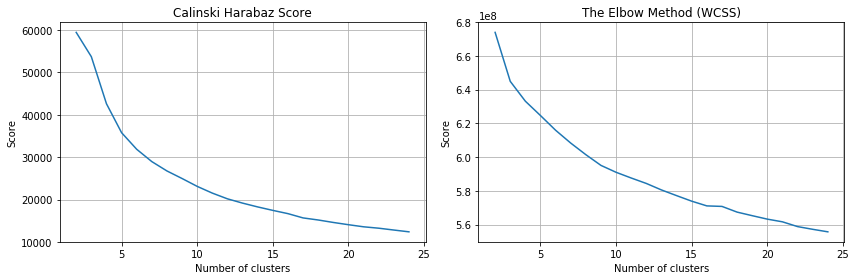

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(2, kmax), cali)
plt.title('Calinski Harabaz Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(2, kmax), wcss)
plt.title('The Elbow Method (WCSS)')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.grid()


plt.tight_layout()

plt.show()

if year != -1: plt.savefig('./ElbowRule'+'_'+str(year)+'.png')
else:          plt.savefig('./ElbowRule.png')



Results : 

2012    4

2013    4

2014    4

Todos   4

In [60]:
"""def elbow_rule(f_train, max_nb_cluster = 10, distortions_method='euclidean', plot=True):

    # k means determine k
    distortions = []

    for k in range(1,max_nb_cluster):
        print('Training K-means models for {} cluster/s...'.format(k))
        kmeanModel = KMeans(n_clusters=k).fit(f_train)
        kmeanModel.fit(f_train)
        if distortions_method == 'euclidean':
            distortions.append(sum(np.min(cdist(f_train, kmeanModel.cluster_centers_, 'euclidean'), \
                                          axis=1)) / f_train.shape[0])
        #elif other distortion evaluation
        
    if plot:
        # Plot the elbow
        plt.figure(figsize=(10,5))
        plt.plot(range(1,max_nb_cluster), distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()"""

"def elbow_rule(f_train, max_nb_cluster = 10, distortions_method='euclidean', plot=True):\n\n    # k means determine k\n    distortions = []\n\n    for k in range(1,max_nb_cluster):\n        print('Training K-means models for {} cluster/s...'.format(k))\n        kmeanModel = KMeans(n_clusters=k).fit(f_train)\n        kmeanModel.fit(f_train)\n        if distortions_method == 'euclidean':\n            distortions.append(sum(np.min(cdist(f_train, kmeanModel.cluster_centers_, 'euclidean'),                                           axis=1)) / f_train.shape[0])\n        #elif other distortion evaluation\n        \n    if plot:\n        # Plot the elbow\n        plt.figure(figsize=(10,5))\n        plt.plot(range(1,max_nb_cluster), distortions, 'bx-')\n        plt.xlabel('k')\n        plt.ylabel('Distortion')\n        plt.title('Elbow Method')\n        plt.show()"

# Visualizing clusters

In [14]:
kmeans = MiniBatchKMeans(n_clusters = 4, init = 'k-means++',
                         n_init=1,init_size= int(1e3),
                         random_state = 42,batch_size=int(1e3))
kmeans.fit(f_train)
ypred = kmeans.predict(f_train)

In [114]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


def plot_pca(f_train, y_train, nb_clusters = 4):

    palette = np.array(sns.color_palette("hls", nb_clusters))

    pca = PCA(n_components=3)
    result = pca.fit_transform(f_train)
    

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(result[:, 0], result[:, 1],result[:, 2],
               s=40, c=palette[ypred.astype(np.int)])

    #    plt.figure(figsize=(8, 8))     
    #    plt.scatter(result[:, 0], result[:, 1], lw=0, s=40,
    #                    c=palette[y_train.astype(np.int)])

    plt.title('Visualization PCA')
    plt.grid()
    plt.show()

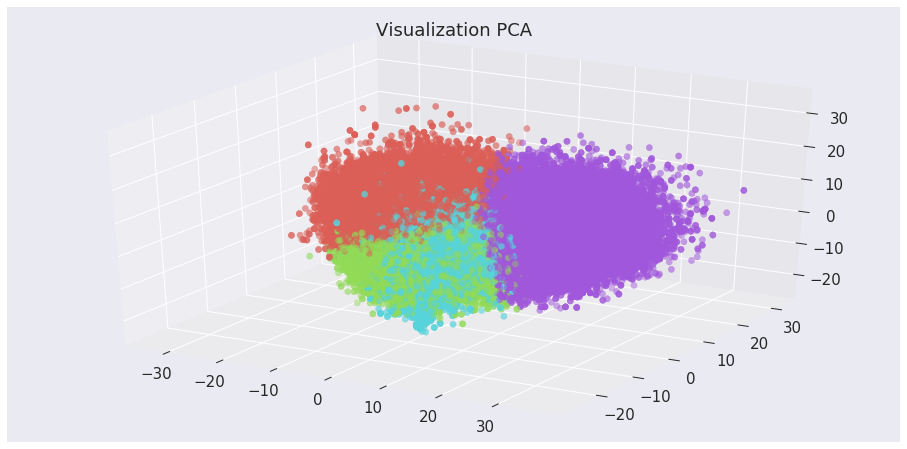

In [115]:
plot_pca(f_train, ypred)

## Words visualization using t-SNE

In [71]:
import bokeh.plotting as bp
from sklearn.manifold import TSNE
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook



def plot_tSNE(model,n_samples = 5000):

    
    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]
    word_centroid_map = dict(zip( W2Vmodel.wv.index2word, ypred ))



    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]

    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [30]:
plot_tSNE(W2Vmodel)

Loading BokehJS ...

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.073s...
[t-SNE] Computed neighbors for 5000 samples in 16.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.250509
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.424141
[t-SNE] Error after 1000 iterations: 2.431944


# Visualizing words in clusters

In [69]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( W2Vmodel.wv.index2word, ypred ))

# For the first 5 clusters
for cluster in range(0,4):
    
    print (f"\n Cluster {cluster}")
    words = []
    for key, value in word_centroid_map.items():
        if( value == cluster ):
            words.append(key)

    print(f'{words[:10]}')


 Cluster 0
['police', 'says', 'govt', 'court', 'nsw', 'qld', 'crash', 'health', 'back', 'murder']

 Cluster 1
['new', 'man', 'council', 'interview', 'death', 'charged', 'report', 'car', 'calls', 'killed']

 Cluster 2
['us', 'fire', 'plan', 'water', 'wa', 'australian', 'woman', 'world', 'government', 'south']

 Cluster 3
['australia', 'sydney', 'call', 'win', 'home', 'missing', 'election', 'set', 'funding', 'group']


# Quantitative Cluster Analysis

In [15]:
ypred.shape

(1000001,)

In [16]:
np.unique(ypred,return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([250232, 244457, 339898, 165414]))

In [17]:
tmp =np.concatenate([f_train,ypred.reshape(-1,1)],axis=1)
tmp.shape

(1000001, 301)

In [18]:
var=[]
for cluster in range(4): 
    var.append(np.var(tmp[tmp[:,-1]==cluster]))

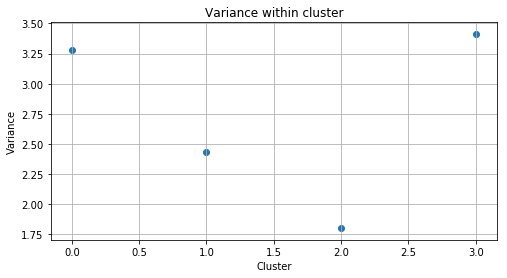

In [22]:
plt.figure(figsize=(8,4))
plt.scatter(range(0, 4), var)
plt.title('Variance within cluster')
plt.xlabel('Cluster')
plt.ticklabel_format(style='plain',axis='x',useOffset=False)
plt.ylabel('Variance')
plt.grid()
plt.show()
plt.savefig('./Variance_4C.png')

# Qualitative Cluster Analysis

In [9]:
def get_corpus(data):
    corpus = []
    for i in data:
        for j in i:
            corpus.append(j)
    return corpus    

In [10]:
def get_wordCloud(corpus):
    
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              random_state=42
                         ).generate(str(text['train'].data['headline_text_data']))
    return wordCloud

In [11]:
procTextCorpus = get_corpus(text['train'].data['headline_text_data'])
rawTextCorpus = get_corpus(text['train'].data['headline_text'])

### Word Cloud Visualization

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [12]:
procWordCloud = get_wordCloud(procTextCorpus)

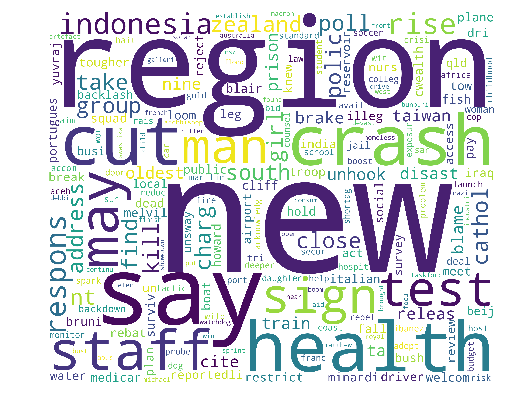

In [13]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(procWordCloud)
plt.axis('off')
plt.show()

### Most frequent words

In [14]:
n_print = 5 # change the number to analyse the # most common words

word_counter = collections.Counter(procTextCorpus)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)

polic :  32878
man :  26457
new :  26347
say :  22453
plan :  20257


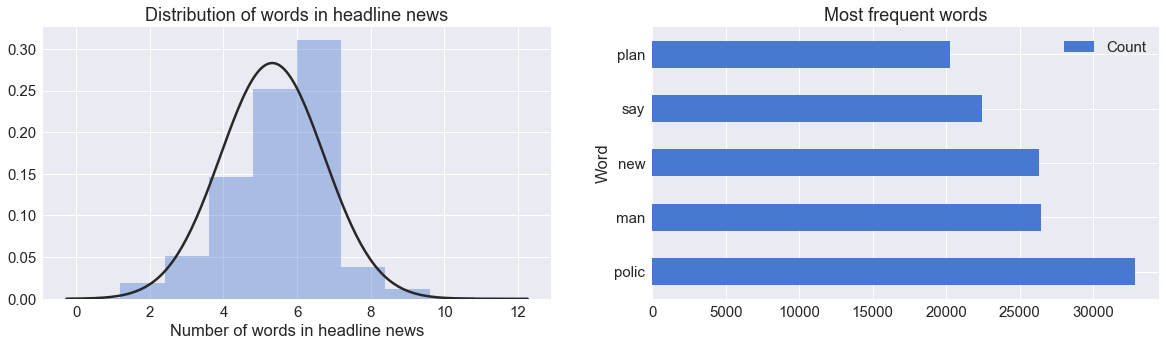

In [15]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)

sns.distplot(text['train'].data['nb_words'],hist=True, kde=False, bins=10, fit=norm)
plt.title("Distribution of words in headline news")
plt.xlabel('Number of words in headline news')

ax = fig.add_subplot(1,2,2)
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
plt.title('Most frequent words')
df.plot(kind="barh",x='Word',y='Count', ax=ax)